In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import shutil
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
print(tf.__version__ )
print(sys.version_info)

for module in mpl, np,pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()

x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(np.max(x_train),np.max(x_valid),np.max(x_test))

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
255 255 255


In [3]:
# x = (x-u)/std
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

print(np.max(x_train_scaled),np.max(x_valid_scaled),np.max(x_test_scaled))

2.023144 2.023144 2.023144


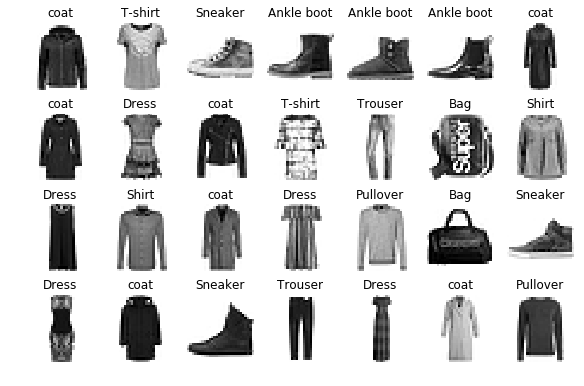

In [4]:
def show_single_image(img_arr):
    plt.imshow(img_arr,cmap="binary")
    plt.show()

def show_imgs(n_rows,n_cols,x_data,y_data, classNames):
    assert len(x_data)== len(y_data)
    assert n_rows*n_cols < len(x_data)
    plt.figure(figsize=(n_cols*1.4,n_rows*1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = row*n_cols+col
            plt.subplot(n_rows,n_cols, index+1)
            plt.imshow(x_data[index],cmap="binary",interpolation="nearest")
            plt.axis('off')
            plt.title(classNames[y_data[index]])
    plt.show()

class_names = ['T-shirt','Trouser','Pullover','Dress','coat','Sandal','Shirt',
               'Sneaker','Bag','Ankle boot']
show_imgs(4,7,x_train,y_train,class_names)

In [9]:
#tf.keras.models.senquential
#建立senquential 模型方式一
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),#将矩阵flat
#     keras.layers.Dense(300,activation="relu"),#全联接层
#     keras.layers.Dense(100,activation="relu"),
#     keras.layers.Dense(10,activation="softmax")
# ])


model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu"))
#    model.add(keras.layers.BatchNormalization())    #批归一化在激活函数之后
        
    """
    #批归一化在激活函数之前
    model.add(keras.layers.Dense(100))              #添加全链接层
    model.add(keras.layers.BatchNormalization())    #批归一化
    model.add(keras.layers.Activation("relu"))      #添加激活函数
    """
#model.add(keras.layers.AlphaDropout(rate=0.5))
#model.add(keras.layers.Dropout(rate=0.5))
#AlphaDropout 1 均值方差不变 2 归一化性质不变 ：可以和批归一化或selu组合使用
model.add(keras.layers.Dense(10,activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", #sparse 的交叉损失熵
             optimizer="adam",
             metrics = ["accuracy"])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [11]:
#Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-relu-callbacks'
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.mkdir(logdir)
    
output_model_file = os.path.join(logdir,
                                "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3), #连续5次损失函数和上一次差距小于1e-3即可停止训练    
]
his = model.fit(x_train_scaled,y_train,epochs=10, 
         validation_data=(x_valid_scaled,y_valid),
                 callbacks = callbacks)  #epochs 训练次数
#终端命令 tensorboard --logdir=callbacks 

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.7109 - accuracy: 0.7577 - val_loss: 0.5102 - val_accuracy: 0.8308
Epoch 2/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.5775 - accuracy: 0.8114 - val_loss: 0.4705 - val_accuracy: 0.8376
Epoch 3/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.5267 - accuracy: 0.8262 - val_loss: 0.6712 - val_accuracy: 0.7620
Epoch 4/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.5234 - accuracy: 0.8252 - val_loss: 0.4681 - val_accuracy: 0.8434
Epoch 5/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.5275 - accuracy: 0.8214 - val_loss: 0.5025 - val_accuracy: 0.8320
Epoch 6/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.5733 - accuracy: 0.8082 - val_loss: 0.5488 - val_accuracy: 0.8142
Epoch 7/10
55000/55000 [===========================

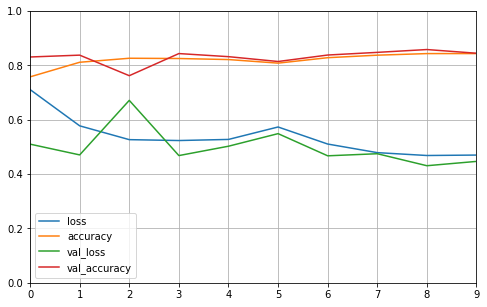

In [12]:
 def plot_learning_curves(his):
        pd.DataFrame(his.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        
plot_learning_curves(his)